In [1]:
%matplotlib inline

import sys
import datetime
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.grid_search import GridSearchCV

from utils import utils as ut
from utils import quandl as ql
from utils import composite
from utils import maps
from settings import TARGET_SERIES, TARGET_INDICATOR

sns.set_style("dark")

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
tar = ql.load_target()
PANEL_SCORE = True

## increasing values

int: 0.000000	coef: 0.540435	r2 score: 0.292070	xs corr: 0.209719


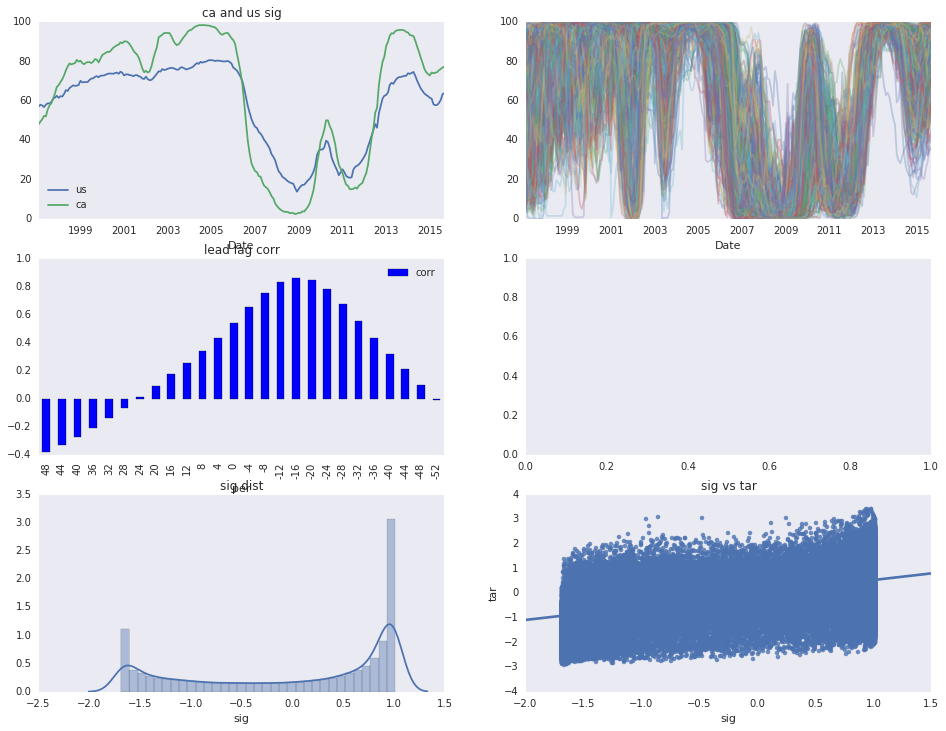

In [4]:
series = 'IV'
px, px_ca, px_us = ql.load_series(series)
composite.explore_series(px, px_ca, px_us, tar)

## decreasing values

int: -0.000000	coef: -0.535861	r2 score: 0.287148	xs corr: -0.200010


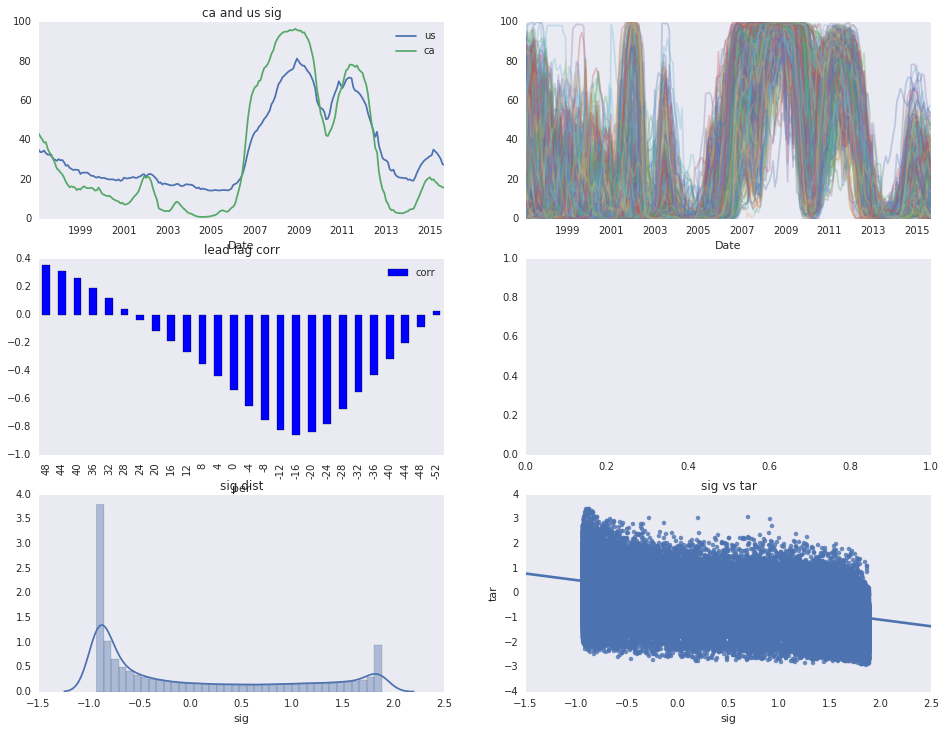

In [5]:
series = 'DV'
px, px_ca, px_us = ql.load_series(series)
composite.explore_series(px, px_ca, px_us, tar)

## ratio sales price to list price

In [7]:
# series = 'SLPR'
# px, px_ca, px_us = ql.load_series(series)
# composite.explore_series(px, px_ca, px_us, tar)

## turnover in housing market in past year

int: -0.000000	coef: 0.122036	r2 score: 0.014893	xs corr: 0.033253


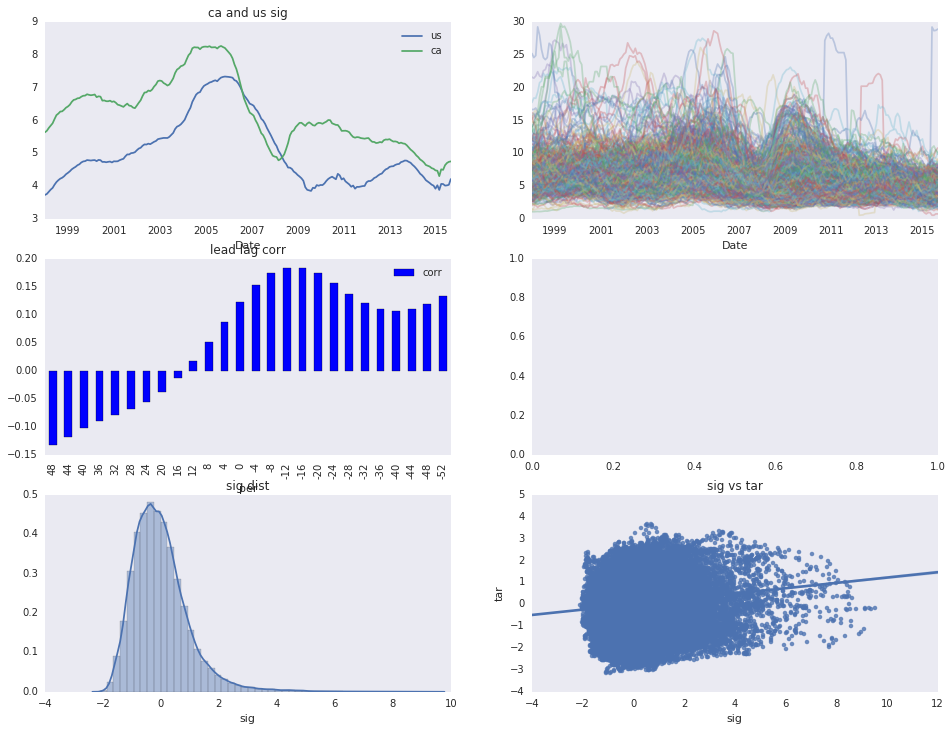

In [8]:
series = 'SPY'
px, px_ca, px_us = ql.load_series(series)
composite.explore_series(px, px_ca, px_us, tar)

## sold for gain

In [9]:
series = 'SFG'
px, px_ca, px_us = ql.load_series(series)

In [10]:
yoy = lambda x: x / x.shift(24) - 1.
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
SFG_c = px

int: 0.000000	coef: 0.220999	r2 score: 0.048840	xs corr: 0.098095


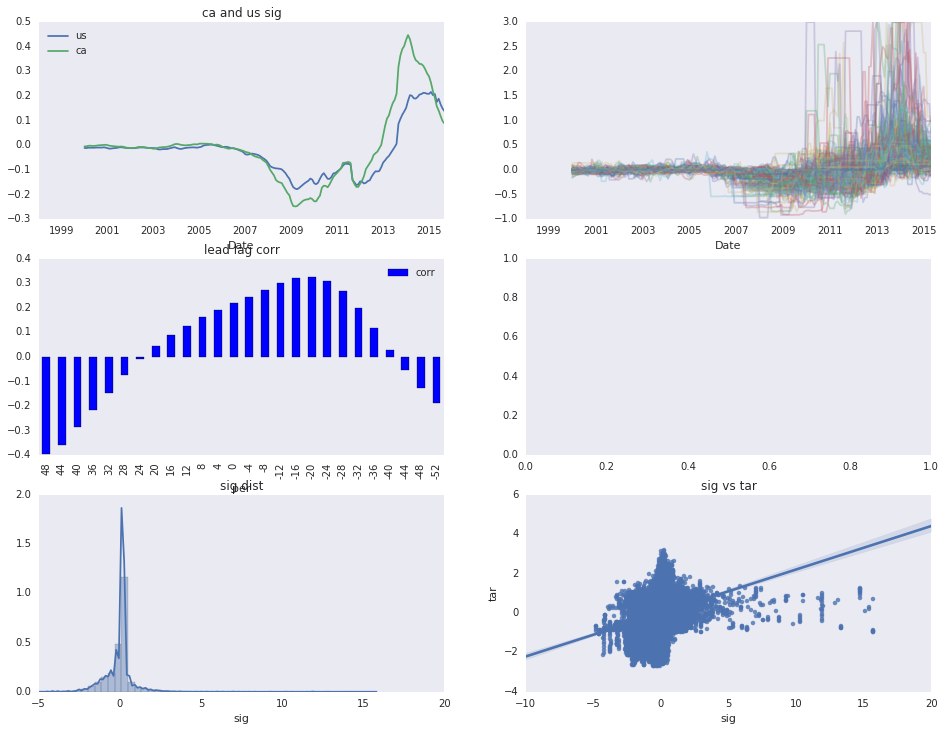

In [11]:
composite.explore_series(px, px_ca, px_us, tar)

# price per square foot

In [12]:
series = 'MVSF'
px, px_ca, px_us = ql.load_series(series)

In [13]:
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
MVSF_c = px

int: -0.000000	coef: 0.347158	r2 score: 0.120519	xs corr: 0.141206


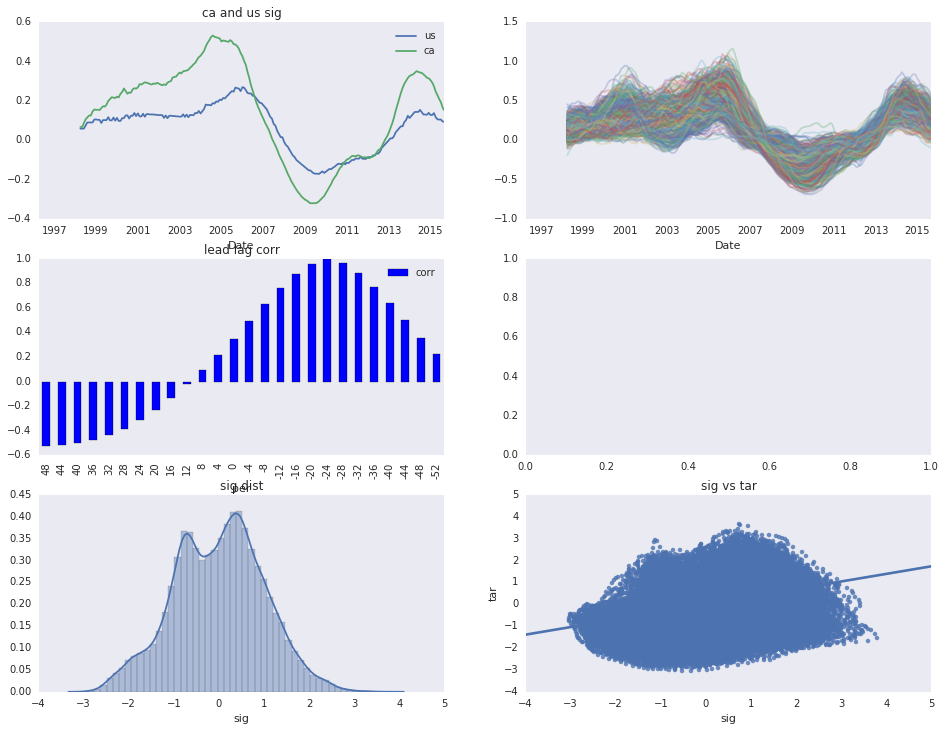

In [14]:
composite.explore_series(px, px_ca, px_us, tar)

# momentum

In [15]:
px, px_ca, px_us = ql.load_series(TARGET_SERIES)

In [16]:
px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
TAR_mom = px

int: -0.000000	coef: 0.329300	r2 score: 0.108439	xs corr: 0.105037


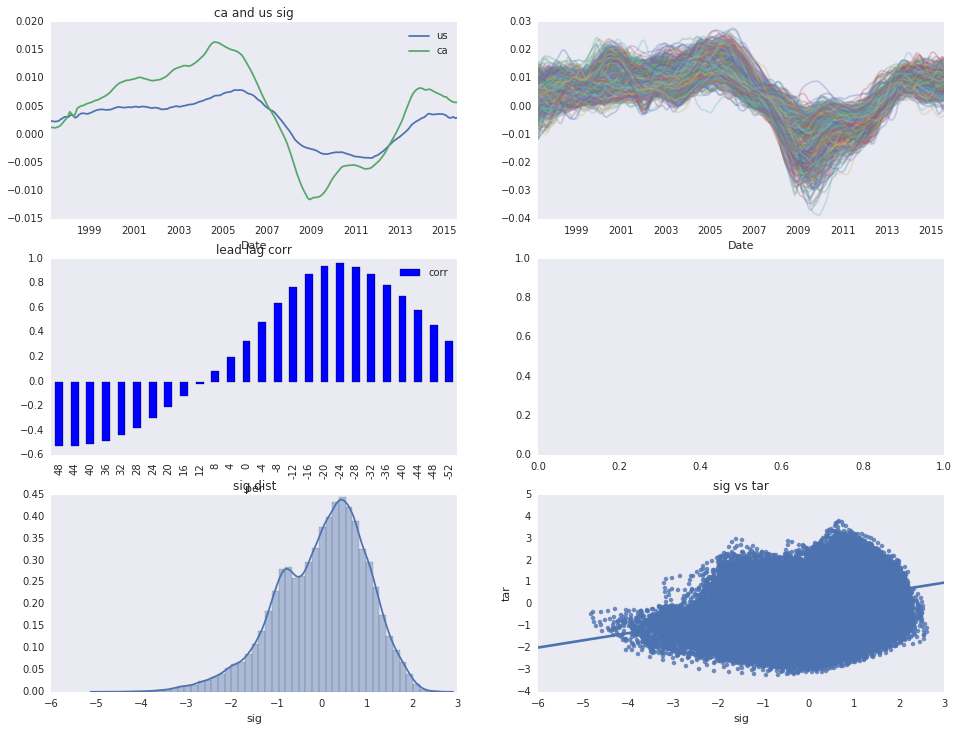

In [17]:
composite.explore_series(px, px_ca, px_us, tar)

# change in momentum

In [18]:
px, px_ca, px_us = ql.load_series(TARGET_SERIES)

In [19]:
def momentum_change(df):
    mom_cur = ut.momentum(df)
    mom_prev = ut.momentum(df.shift(12))
    return (mom_cur - mom_prev).dropna(how='all')

In [20]:
px, px_ca, px_us = ut.capped_transformation(momentum_change, px, px_ca, px_us)
TAR_mom_chg = px

int: -0.000000	coef: 0.548716	r2 score: 0.301089	xs corr: 0.271026


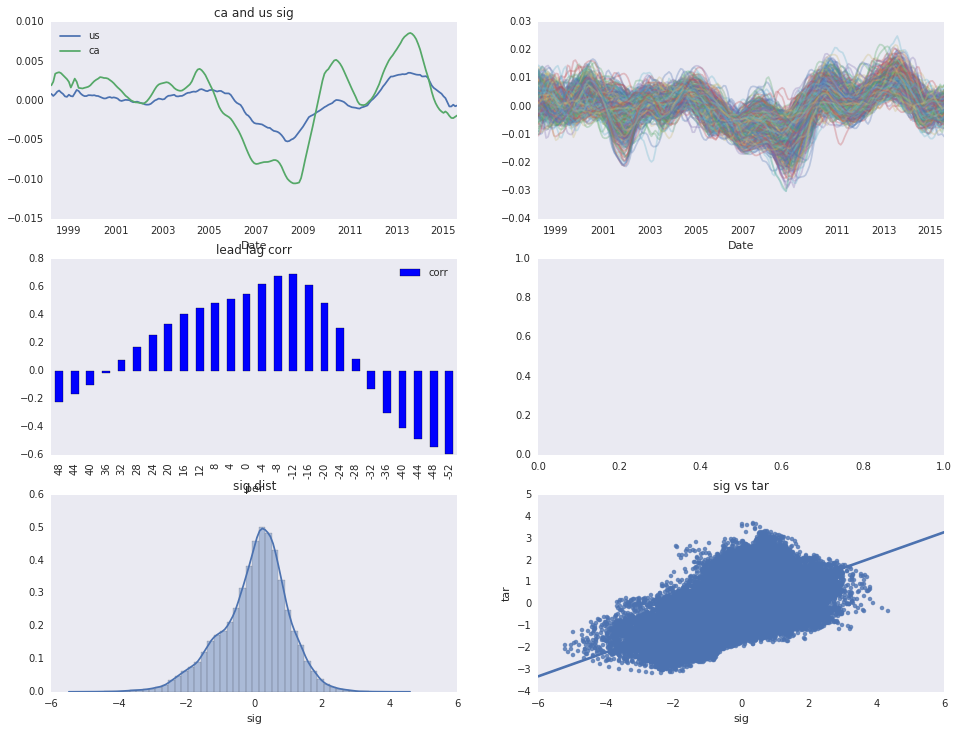

In [21]:
composite.explore_series(px, px_ca, px_us, tar)

## build model

In [41]:
features = {}
for i in ('IV', 'DV', 'SPY'):#, 'SLPR'):
    px = ql.load_quandl_data(TARGET_INDICATOR, i)
    px = (px.fillna(method='ffill', limit=3).dropna(axis=1))
    features[i] = px
features['tar'] = tar
features['SFG'] = SFG_c
features['MVSF'] = MVSF_c
features['TAR_mom'] = TAR_mom
features['TAR_mom_chg'] = TAR_mom_chg

df = ut.stack_and_align(features.values(), cols=features.keys()).dropna()
df.index.levels[1].name = 'code'

In [23]:
print(df.IV.unstack().dropna(how='all').shape)
print(df.DV.unstack().dropna(how='all').shape)
print(df.SPY.unstack().dropna(how='all').shape)
#print(df.SLPR.unstack().dropna(how='all').shape)
print(df.tar.unstack().dropna(how='all').shape)
print(df.MVSF.unstack().dropna(how='all').shape)
print(df.TAR_mom.unstack().dropna(how='all').shape)
print(df.TAR_mom_chg.unstack().dropna(how='all').shape)

(164, 180)
(164, 180)
(164, 180)
(164, 180)
(164, 180)
(164, 180)
(164, 180)


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


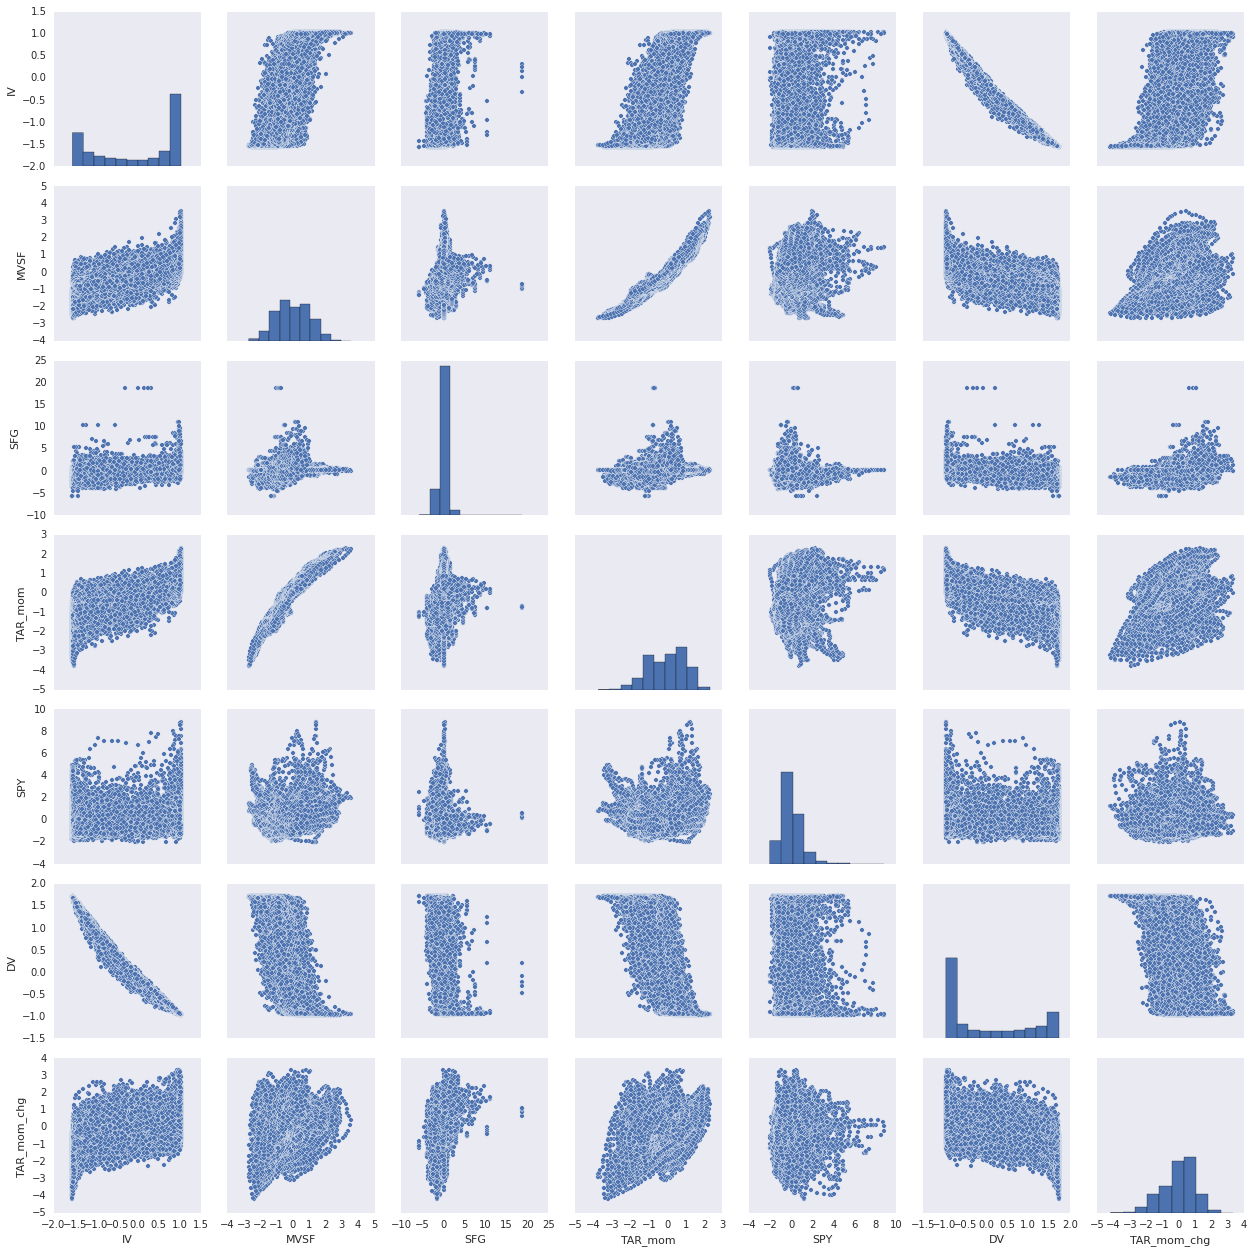

In [31]:
sns.pairplot(ut.ts_score(df[[c for c in df.columns if c != 'tar']], panel=PANEL_SCORE))

sharpe ratios:
0.2    1.008919
0.4    1.707261
0.6    2.081112
0.8    2.308431
1.0    2.213529
mkt    1.639003
dtype: float64
r2: 0.328049	xs corr: 0.307812
int: 0.000000	coef: [ 0.10747758  0.04454685  0.0291748   0.03116867  0.00889167 -0.10136231
  0.15707261]	alpha: 50000


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


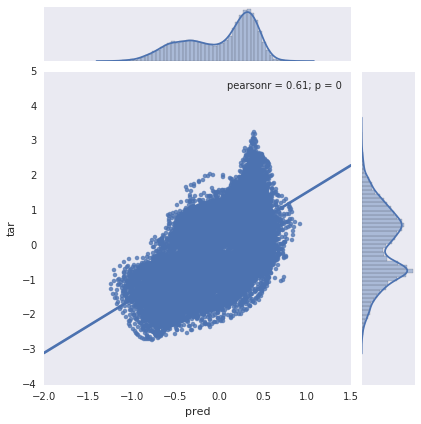

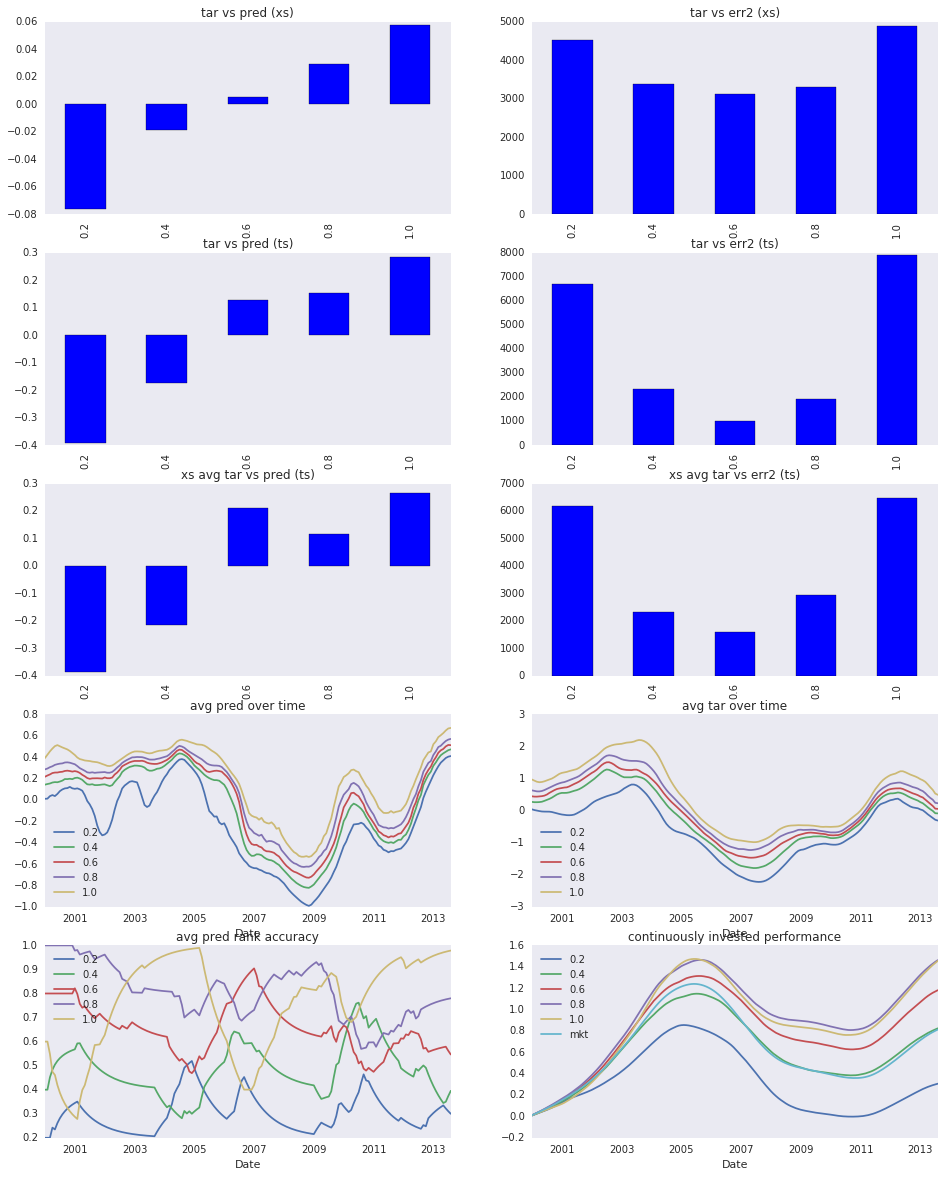

In [33]:
clf = lm.RidgeCV(alphas=[1., 10., 100, 1000, 10000, 50000, 10000000], cv=5)
clf, df_res, score, pred = composite.build_model(clf, df, PANEL_SCORE)
print('int: {0:03f}\tcoef: {1}\talpha: {2}'.format(clf.intercept_, clf.coef_, clf.alpha_)) 

In [34]:
pred.reset_index().to_csv('data/processed/pred.csv', index=False)

show prediction in map

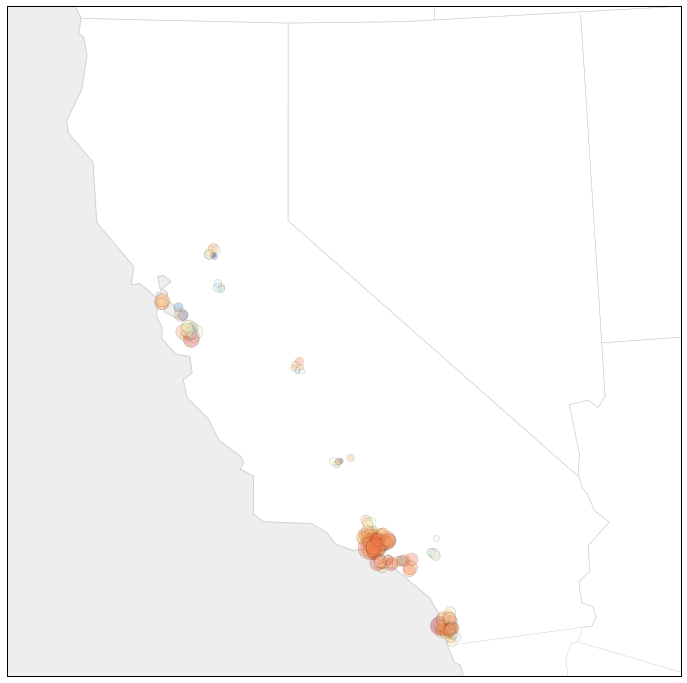

In [43]:
map_pred = maps.load_pred_for_map()
cm = plt.cm.get_cmap('RdYlBu')
m = maps.draw_CA()
row = map_pred.loc[map_pred.index.levels[0][-1]]
style = dict(marker='o', alpha=0.3, zorder=2, latlon=True, label='cities', cmap=cm)
m.scatter(row.lon.values, row.lat.values, s=row.px.map(lambda x: x * .00025).values, c=row.pred.values, **style)

sharpe ratios:
0.2    0.963557
0.4    1.644036
0.6    2.067889
0.8    2.328384
1.0    2.324369
mkt    1.639003
dtype: float64
r2: 0.394448	xs corr: 0.328267
int: 3.2073388058641592e-15	coef: [ 0.26760759  0.          0.          0.          0.         -0.
  0.32050531]	alpha: 0.1


/home/condauser/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/base.py:400: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':
/home/condauser/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/base.py:400: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':
/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


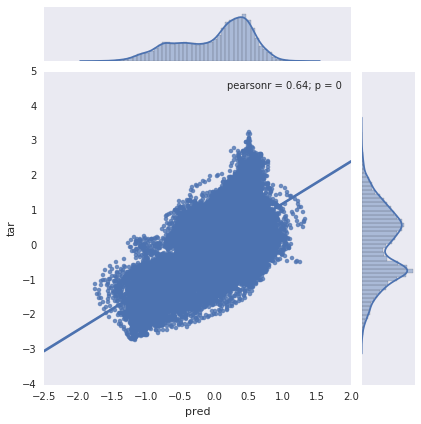

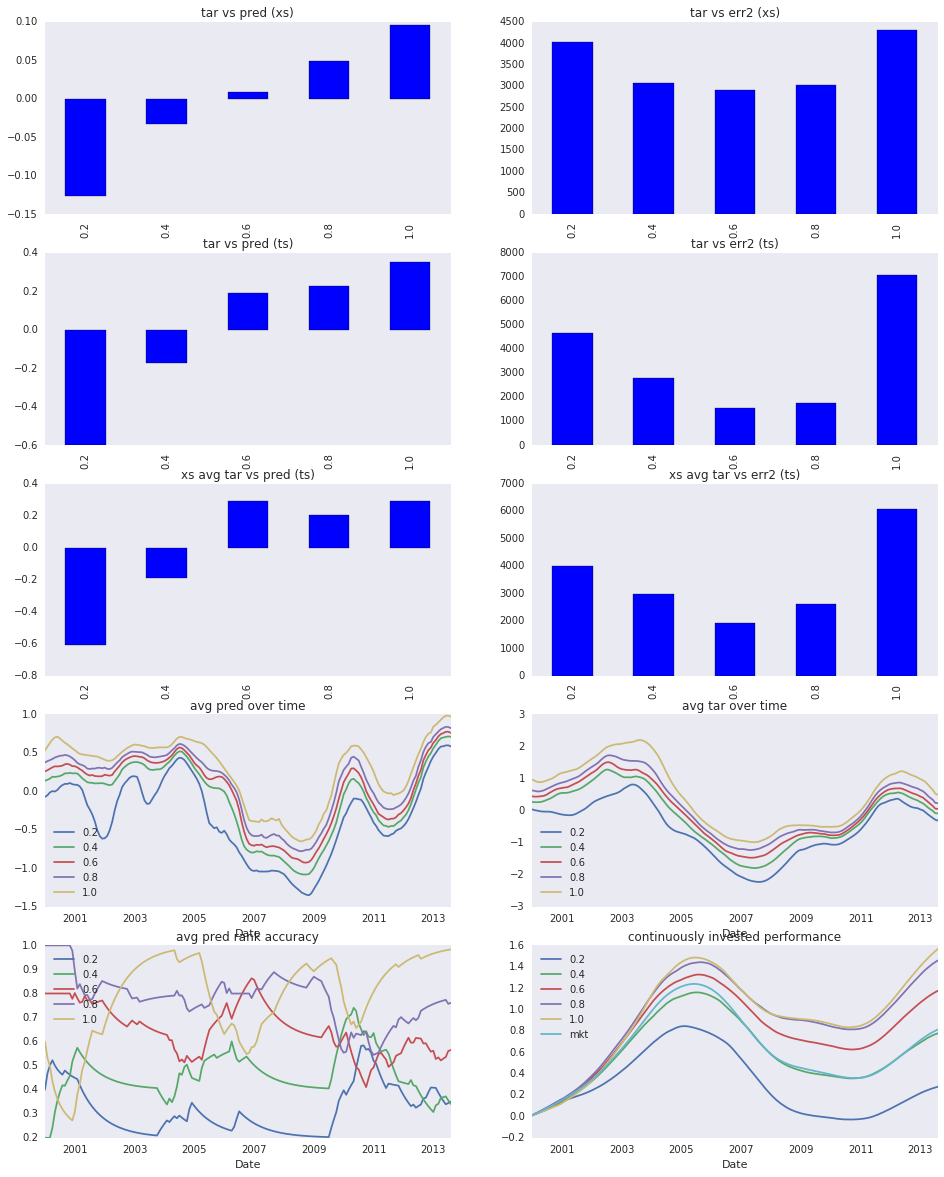

In [44]:
clf = lm.LassoCV(alphas=[.0001, .001, .01, .1], cv=5)
clf, df_res, score, pred = composite.build_model(clf, df, PANEL_SCORE)
print('int: {0}\tcoef: {1}\talpha: {2}'.format(clf.intercept_, clf.coef_, clf.alpha_))

sharpe ratios:
0.2     2.275570
0.4     0.180759
0.6    -1.374090
0.8    -6.550366
1.0   -45.507619
mkt     1.402553
dtype: float64
r2: 0.383041	xs corr: 0.155845
DecisionTreeRegressor(compute_importances=None, criterion='mse', max_depth=2,
           max_features=2, max_leaf_nodes=None, min_density=None,
           min_samples_leaf=1, min_samples_split=2, random_state=None,
           splitter='best')


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


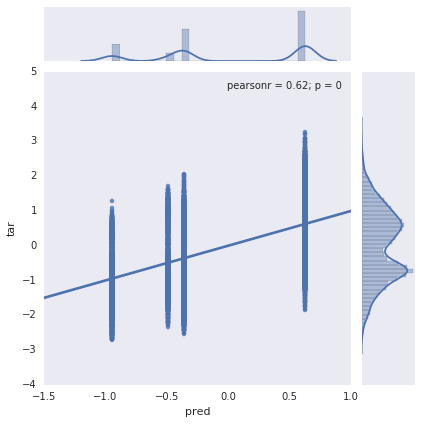

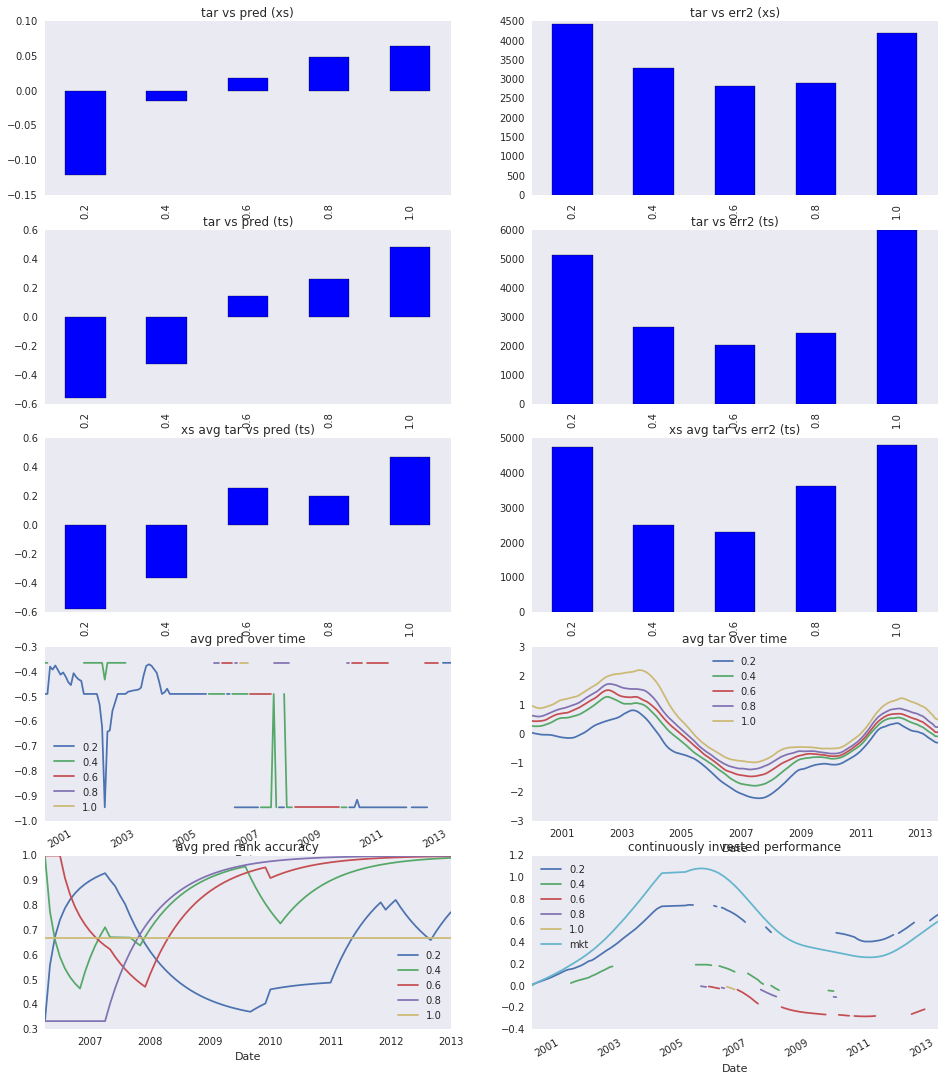

In [45]:
clf = GridSearchCV(tree.DecisionTreeRegressor(), param_grid={'max_depth': [2,3,5], 'max_features': [None, 1, 2]}, cv=5)
clf, df_res, score, pred = composite.build_model(clf, df, PANEL_SCORE)
print(clf.best_estimator_)
#ut.tree_vis(clf.best_estimator_)

sharpe ratios:
0.2    1.193984
0.4    1.761900
0.6    2.010033
0.8    2.031169
1.0    1.612114
mkt    1.639003
dtype: float64
r2: 0.395564	xs corr: 0.224689


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=2, max_features=1,
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0)

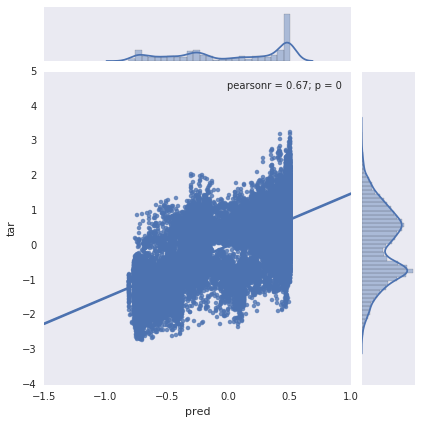

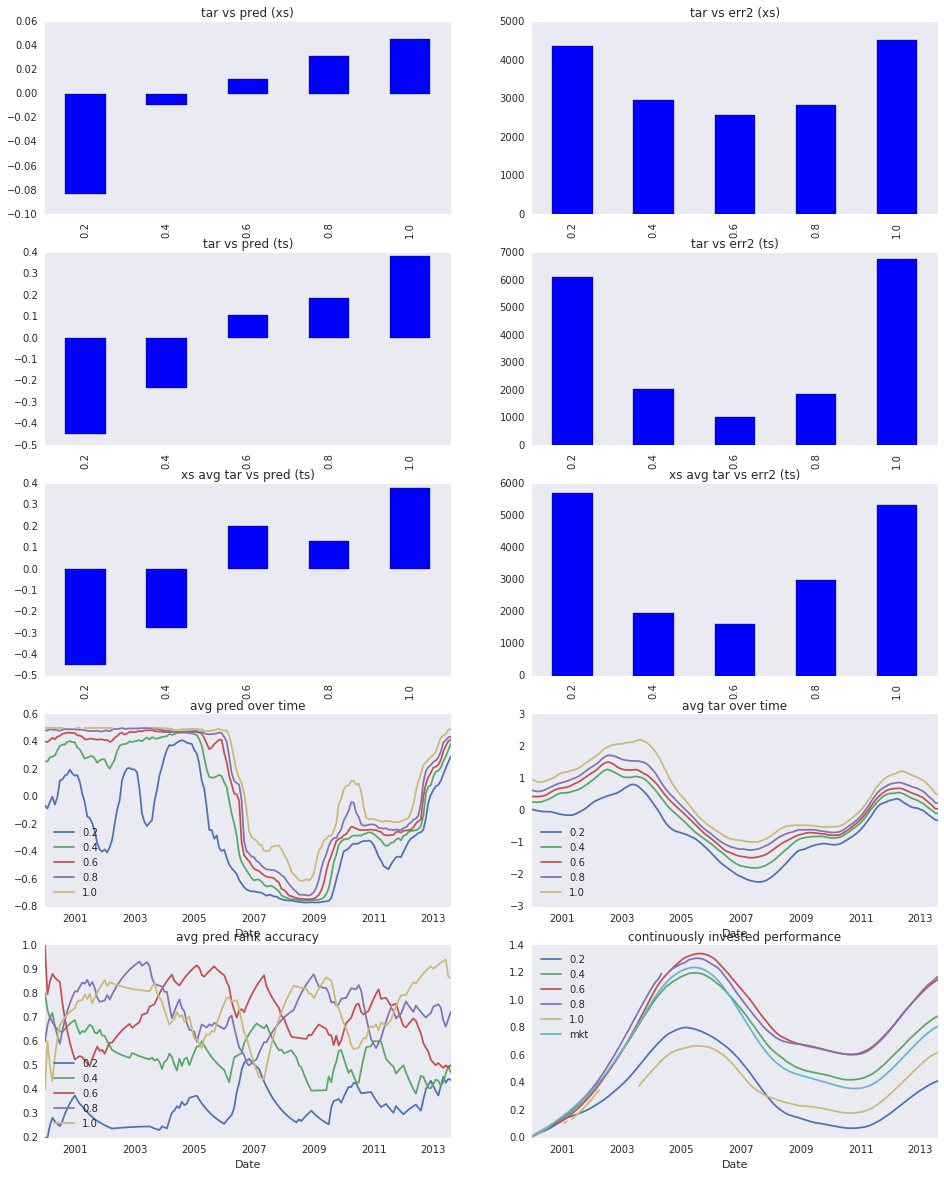

In [46]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=100), param_grid={'max_depth': [2,3,5,7], 'max_features': [None, 1, 2, 4]}, cv=5, n_jobs=1)
clf, df_res, score, pred = composite.build_model(clf, df, PANEL_SCORE)
clf.best_estimator_

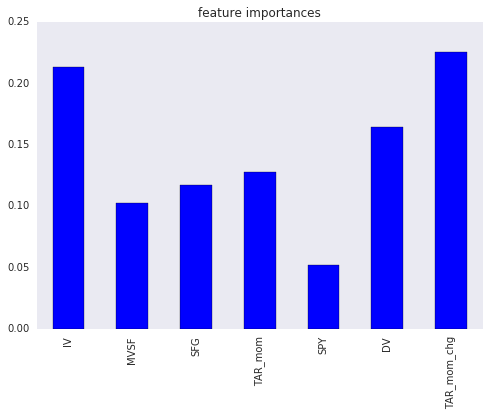

In [47]:
(pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

sharpe ratios:
0.2    0.602214
0.4    1.577820
0.6    2.059837
0.8    2.412101
1.0    2.707361
mkt    1.639003
dtype: float64
r2: 0.768703	xs corr: 0.482694


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=5, max_features=1, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2, n_estimators=200,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

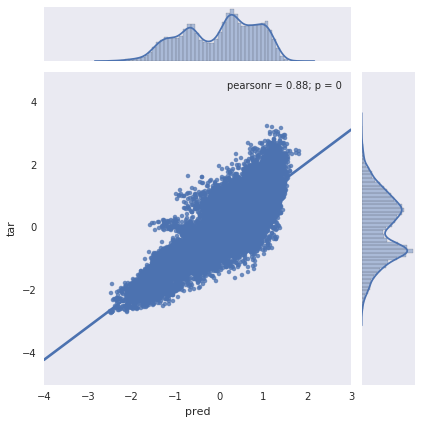

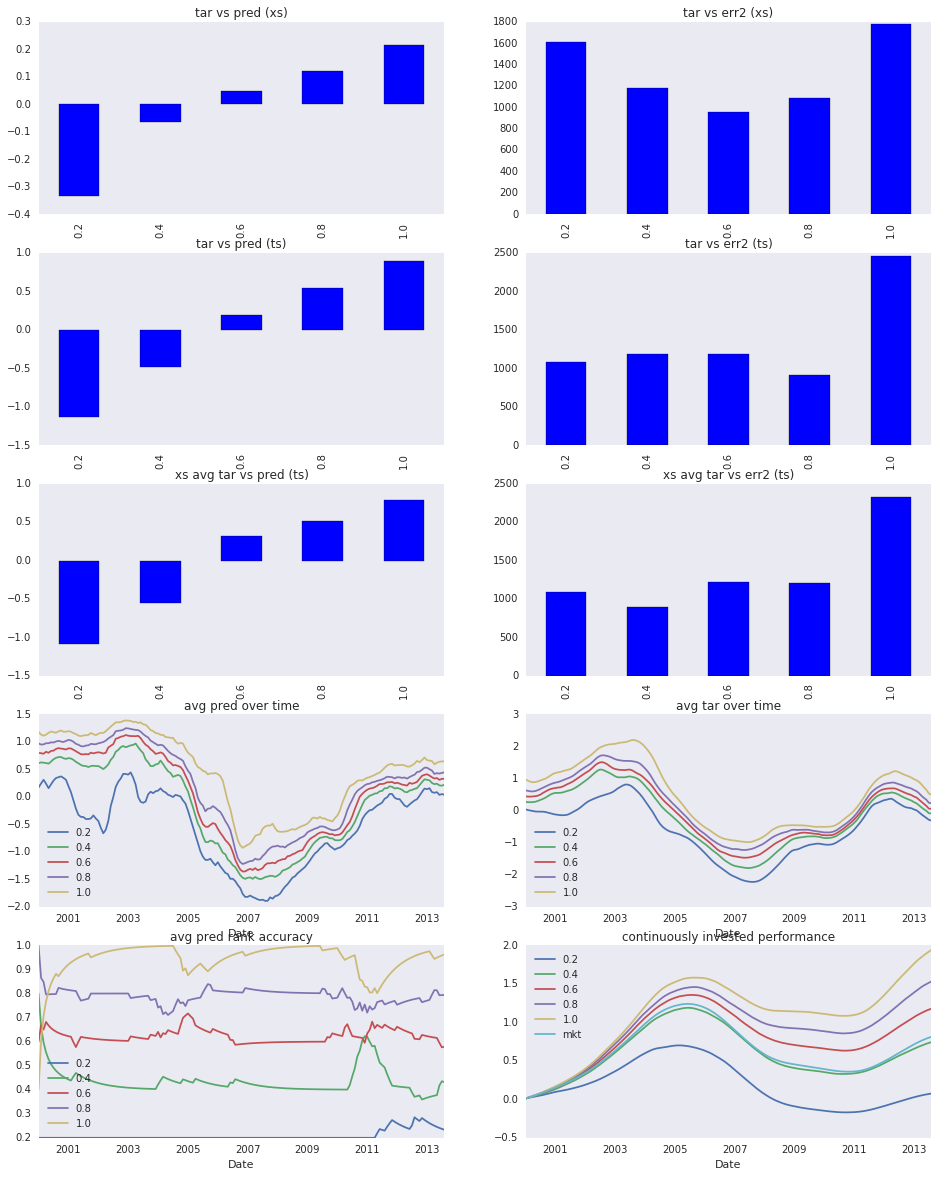

In [49]:
clf = GridSearchCV(GradientBoostingRegressor(), param_grid={'n_estimators': [50, 200],
                                                            'max_depth': [1,3,5], 
                                                            'max_features': [None, 1, 2]}, 
                   cv=5, n_jobs=2)
clf, df_res, score, pred = composite.build_model(clf, df, PANEL_SCORE)
clf.best_estimator_

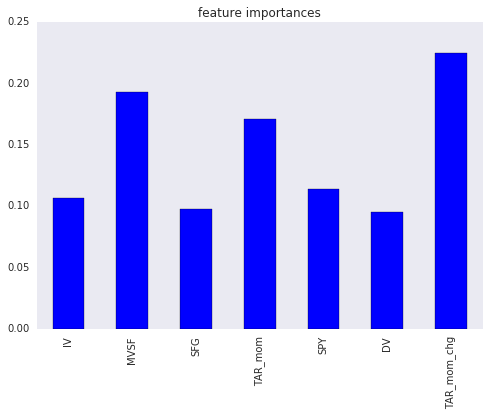

In [50]:
(pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

In [51]:
pred.reset_index().to_csv('data/processed/pred.csv', index=False)

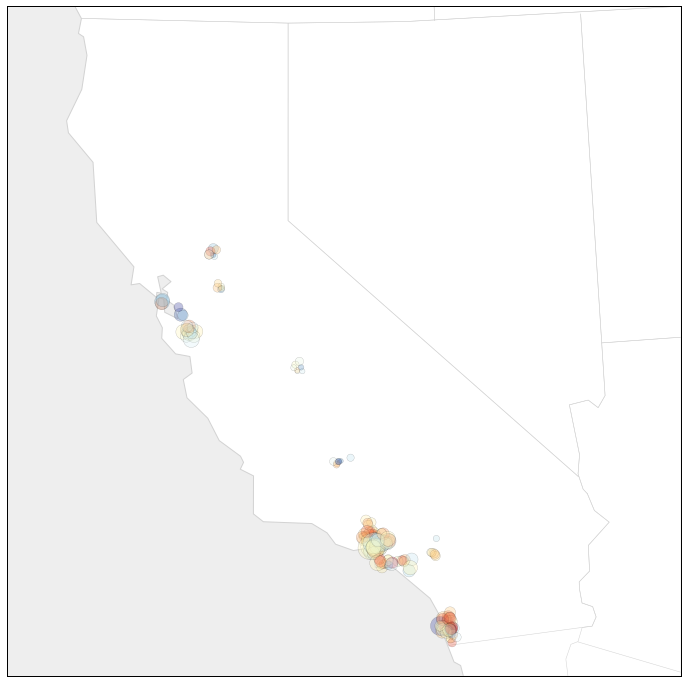

In [52]:
map_pred = maps.load_pred_for_map()
cm = plt.cm.get_cmap('RdYlBu')
m = maps.draw_CA()
row = map_pred.loc[map_pred.index.levels[0][-1]]
style = dict(marker='o', alpha=0.3, zorder=2, latlon=True, label='cities', cmap=cm)
m.scatter(row.lon.values, row.lat.values, s=row.px.map(lambda x: x * .00025).values, c=row.pred.values, **style)